In [101]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression



In [102]:
import warnings

warnings.filterwarnings('ignore')

In [103]:
import pandas as pd

df = df = pd.read_csv('data/Autism Dataset for Toddlers.csv')
df.head()


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [104]:
df.describe()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,527.500000,0.563567,0.448767,0.401328,0.512334,0.524668,0.576850,0.649905,0.459203,0.489564,0.586338,27.867173,5.212524
std,304.407895,0.496178,0.497604,0.490400,0.500085,0.499628,0.494293,0.477226,0.498569,0.500128,0.492723,7.980354,2.907304
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,3.000000
50%,527.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.000000,5.000000
75%,790.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,8.000000
max,1054.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,10.000000


In [105]:
df.isna().any()


Case_No                   False
A1                        False
A2                        False
A3                        False
A4                        False
A5                        False
A6                        False
A7                        False
A8                        False
A9                        False
A10                       False
Age_Mons                  False
Qchat-10-Score            False
Sex                       False
Ethnicity                 False
Jaundice                  False
Family_mem_with_ASD       False
Who completed the test    False
Class/ASD Traits          False
dtype: bool

In [106]:
df.rename(columns={'Class/ASD Traits ': 'Class/ASD Traits'}, inplace=True)

encoder = LabelEncoder()

df['Class/ASD Traits'] = encoder.fit_transform(df['Class/ASD Traits'])
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,1


#Data Analysis

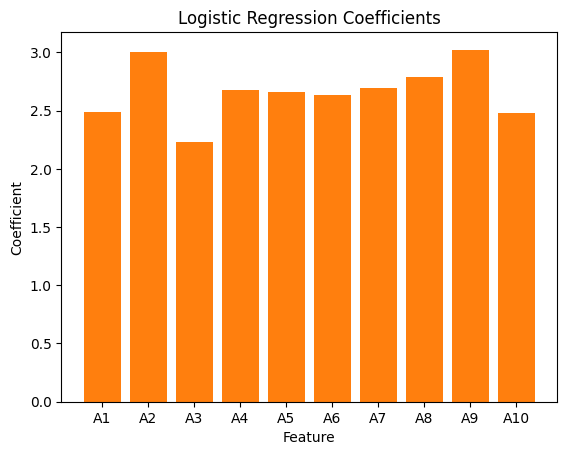

In [107]:
correlation = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Class/ASD Traits']].corr()


X = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']]
y = df['Class/ASD Traits']

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Get coefficients
coefficients = model.coef_


# Bar plot of correlation coefficients
sb.barplot(x=correlation.columns[:-1], y=correlation['Class/ASD Traits'][:-1])

# Coefficient plot from logistic regression
plt.bar(X.columns, coefficients[0])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Logistic Regression Coefficients')
plt.show()